# Conducting an end-to-end anaylsis using the `torchdms` API

First, we will import the following packages for this tutorial:

* `torchdms` for analyzing DMS data
* `pkg_resources` for retrieving pre-packeged example data
* `pandas` for manipulating data frames

In [1]:
import torch
import os
from torchdms.utils import (
    from_pickle_file
)
from torchdms.data import (
    partition, 
    SplitDataset,
    prep_by_stratum_and_export
)
import torchdms.model
import torchdms.evaluation
import torchdms.plot
from torchdms.analysis import Analysis
from torchdms.loss import l1
import pkg_resources
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt

## Loading example data and preparing for analysis

We will first retrieve a link to the testing data and partition it into train-val-test splits, similar to `tdms prep`:

In [2]:
data_path = pkg_resources.resource_filename("torchdms", "data/test_df.pkl")

In [3]:
data, wtseq = from_pickle_file(data_path)

Now we will partition our DMS variants into train-val-test splits:

In [4]:
split_df = partition(
            data,
            per_stratum_variants_for_test=10,
            skip_stratum_if_count_is_smaller_than=30,
            strata_ceiling=None,
            export_dataframe=None,
            partition_label=None)

To create one-hot representations compatiable with `torchdms` models, the last step is to call `prep_by_stratum_and_export()`, which takes the partitioned data, creates the one-hot encodings, and groups the training data by amino-acid mutation number. 

After dumping this object to `test_df.prepped.pkl`, we can load this back in using `torchms.utils.from_pickle_file()`

In [5]:
prep_by_stratum_and_export(split_df, wtseq, ["affinity_score"], "test_df.prepped", "", None)
split_df_prepped = from_pickle_file("test_df.prepped.pkl")

LOG: There are 18 training samples for stratum: 1
LOG: There are 30 training samples for stratum: 2
LOG: There are 30 training samples for stratum: 3
LOG: There are 37 validation samples
LOG: There are 35 test samples
LOG: Successfully partitioned data
LOG: preparing binary map dataset


## Creating and training a `torchdms` model

To create a `torchdms` model, we provide an architechture by specifying the number of nodes, corresponding activations, and input size. We also include the names of the targets we seek to model as well as the amino acid alphabet allowed.
We then save this model to a path so we can load it for downstream analysis.
By default, we will also create a pickle file of model details (i.e., unseen mutations) in `run.model_details.pkl`

In [6]:
model_path = 'run.model'
model = torchdms.model.FullyConnected(
        [1, 10],
        [None, nn.ReLU()],
        split_df_prepped.test.feature_count(),
        split_df_prepped.test.target_names,
        split_df_prepped.test.alphabet,
    )
torch.save(model, model_path)

To train our model, we must define an `Analysis` object, which takes in the model and its path, as well as validation and training data.

In [7]:
analysis_params = {
    "model": model,
    "model_path": model_path,
    "val_data": split_df_prepped.val,
    "train_data_list": split_df_prepped.train,
}
analysis = Analysis(**analysis_params)

To conduct training, we define the number of epochs we'd like to train for, a loss function, as well as any other hyperparameters. In this example, we use the two required arguments, and only train for one epoch.

In [8]:
training_params = {"epoch_count": 1, "loss_fn": l1}
analysis.train(**training_params)

Training in default style.


validation loss record: 0.8846588134765625


## Evaluating the model fit with `torchdms` plots

Most plotting functionality first requires evaluation on the testing dataset. We can do that with `torchdms.evaluation.build_evaluation_dict()`, which takes a model and the testing data to make out-of-sample predictions:

In [9]:
eval_dict = torchdms.evaluation.build_evaluation_dict(model, split_df_prepped.test)

We can then make a scatter plot and a corresponding csv file of the test data vs the predicted values by passing in the evaluation dict, the model object, as well as a path to output the plot:

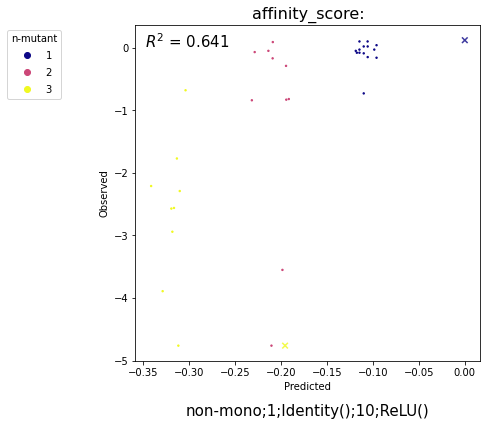

In [10]:
torchdms.plot.plot_test_correlation(eval_dict, model, out='scatter.png')

We follow the same formula for heatmaps of the single mutant predictions as well as the beta coefficients/latent effects:

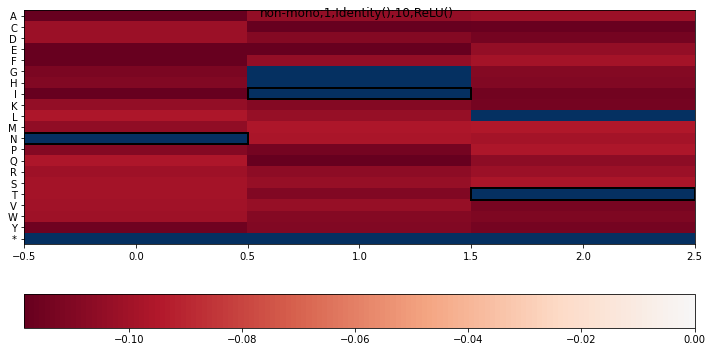

In [11]:
torchdms.plot.plot_heatmap(model, split_df_prepped.test, 'heat.png')

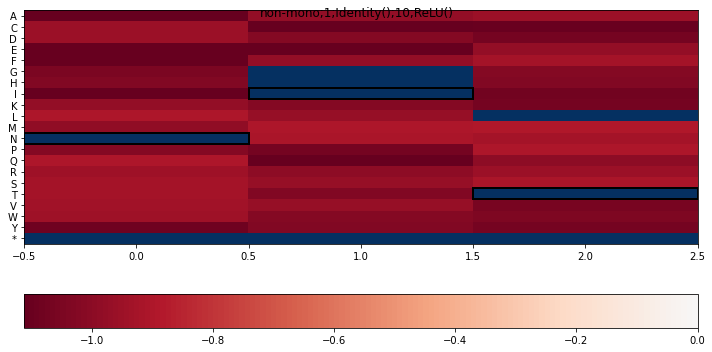

In [12]:
torchdms.plot.beta_coefficients(model, split_df_prepped.test, 'beta.png')

Creating a global epistasis plot requires a dataframe containing latent values of the test variants as well as their observed and predicted values. We can do this with `torchdms.plot.build_ge_plot_df()`:

In [13]:
ge_df = torchdms.plot.build_geplot_df(model, split_df_prepped.test)

And finally, we can dump the plot to `ge.png` using the following command:

In [14]:
%%capture output
torchdms.plot.plot_geplot(ge_df, path="ge.png", title='Global epistasis plot' )

NOTE: as of now, `torchdms.plot` uses the `Plotnine` package for creating 1d and 2d global epistasis plots.
The current implementation does not support rendering in a jupyter notebook.

Below, we clear all of the files created in this notebook using the `os` package:

In [15]:
os.remove(model_path)
os.remove('run.model_details.pkl')
os.remove('test_df.prepped.pkl')
os.remove('scatter.png')
os.remove('heat.png')
os.remove('beta.png')
os.remove('ge.png')
os.remove('scatter.corr.csv')